In [1]:

!pip install finta
! pip install backtesting



In [2]:
# importing necessary files and dependencies

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import yfinance as yahooFinance
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset

from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report

from finta import TA
from backtesting.test import  SMA
from backtesting import Backtest , Strategy
from backtesting.lib import crossover

import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '



## **Step 1: Import the OHLCV dataset into a Pandas DataFrame**

In [3]:
# download data from yahoo finance for ticker from past 5 years from now
end_date= datetime.now()
start_date=end_date - timedelta(days=7*365)
apple_df = yahooFinance.download("AAPL", start=start_date, end=end_date, period='1d')

[*********************100%%**********************]  1 of 1 completed


In [4]:
apple_df.shape

(1760, 6)

# **Building a BaseLine Trading Strategy Using MACD**

In [5]:
# Create a new clean copy of the signals_df DataFrame
macd_signals_df =apple_df.copy()
macd_signals_df["Actual Returns"] = macd_signals_df["Close"].pct_change().dropna()

# Review the DataFrame
macd_signals_df.head()

,Open,High,Low,Close,Adj Close,Volume,Actual Returns
Date,,,,,,,
2017-02-21,34.057499,34.187500,33.994999,34.174999,31.902100,98028800,NaN
2017-02-22,34.107498,34.279999,34.027500,34.277500,31.997778,83347600,0.002999
2017-02-23,34.345001,34.369999,34.075001,34.132500,31.862425,83152800,-0.004230
2017-02-24,33.977501,34.165001,33.820000,34.165001,31.892769,87106400,0.000952
2017-02-27,34.285000,34.360001,34.070000,34.232498,31.955765,81029600,0.001976


## **Step 2: Generate trading signals using Moving Average Convergence/Divergence(MACD).**

In [6]:
#Creating a function to calculate technical indicator "MACD","BBAND","RSI" from Finta
# data source is the original_df
def MACD_Ind(data):
    macd_df = TA.MACD(data)
    return macd_df

In [7]:
# Concatenate the MACD to the macd_signal_df
macd_signals_df = pd.concat([macd_signals_df, MACD_Ind(apple_df)], axis=1)

# Review the DataFrame
macd_signals_df.iloc[17:25, :]

,Open,High,Low,Close,Adj Close,Volume,Actual Returns,MACD,SIGNAL
Date,,,,,,,,,
2017-03-16,35.180000,35.255001,35.064999,35.172501,32.833256,76928000,0.001637,0.094530,0.068535
2017-03-17,35.250000,35.250000,34.972500,34.997501,32.669895,175540000,-0.004975,0.095282,0.073963
2017-03-20,35.099998,35.375000,35.057499,35.365002,33.012962,86168000,0.010501,0.118666,0.083008
2017-03-21,35.527500,35.700001,34.932499,34.959999,32.634880,158119600,-0.011452,0.108517,0.088157
2017-03-22,34.962502,35.400002,34.939999,35.355000,33.003613,103440800,0.011299,0.125861,0.095754
2017-03-23,35.314999,35.395000,35.152500,35.230000,32.886929,81385200,-0.003536,0.129328,0.102509
2017-03-24,35.375000,35.435001,35.087502,35.160000,32.821594,89582400,-0.001987,0.125682,0.107165
2017-03-27,34.847500,35.305000,34.654999,35.220001,32.877605,94300400,0.001707,0.125540,0.110854


In [8]:
macd_signals_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Actual Returns',
       'MACD', 'SIGNAL'],
      dtype='object')

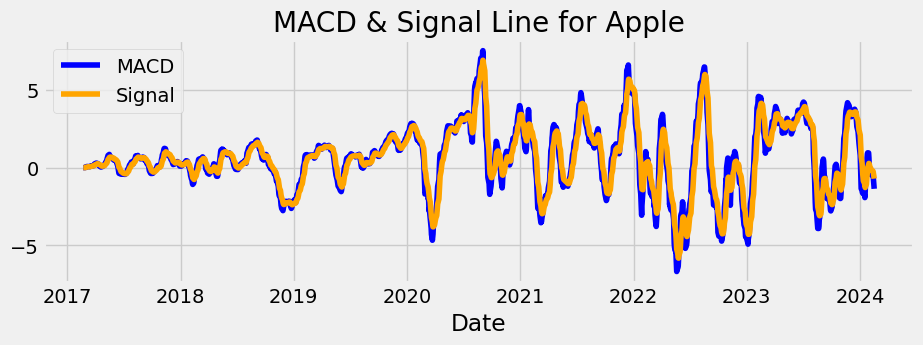

In [9]:
# Plot MACD and Signal to view its working

plt.figure(figsize=(10,3))
plt.plot(macd_signals_df["MACD"],label="MACD",color="blue")
plt.plot(macd_signals_df["SIGNAL"],label="Signal",color="orange")
plt.legend()
plt.title("MACD & Signal Line for Apple")
plt.xlabel("Date")
plt.show()

In [10]:
# cerated two empty lists to hold buy and sell values
buy,sell=[],[]

# iterate through dataframe to extract buy and sell data
for i in range (2,len(macd_signals_df)):
  if macd_signals_df.MACD.iloc[i] > macd_signals_df.SIGNAL.iloc[i] and macd_signals_df.MACD.iloc[i-1] < macd_signals_df.SIGNAL.iloc[i-1]:
    buy.append(i)
  elif macd_signals_df.MACD.iloc[i] < macd_signals_df.SIGNAL.iloc[i] and macd_signals_df.MACD.iloc[i-1] > macd_signals_df.SIGNAL.iloc[i-1]:
    sell.append(i)

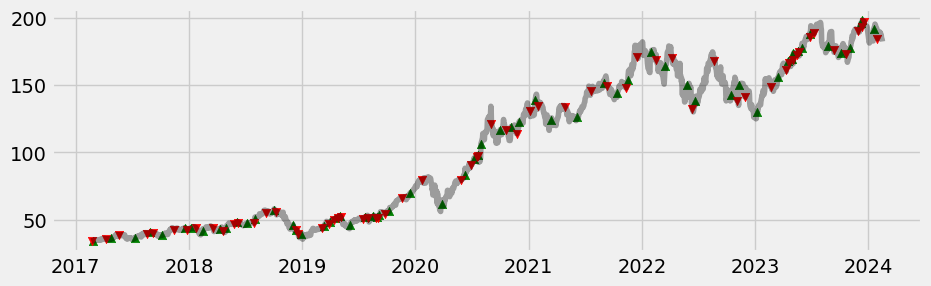

In [11]:
 # Plot closing Price and MACD Indicator to examine performance of indicator
plt.figure(figsize=(10,3))
plt.plot(macd_signals_df.Close,label="APPLE_Close",color='k',alpha=0.35)
plt.scatter(macd_signals_df.iloc[buy].index,macd_signals_df.iloc[buy].Close,marker="^",color='green',alpha=1,label='buy')
plt.scatter(macd_signals_df.iloc[sell].index,macd_signals_df.iloc[sell].Close,marker="v",color='red',alpha=1,label='sell')

# plt.legend()
# plt.title("Close Price Buy & Sell Signals-SPY")
# plt.xlabel("Date")
# plt.ylabel("Close Price")
# plt.show()

```
A crossover occurs when the signal and MACD line cross each other.
 The MACD generates a bullish signal when it moves above its own nine-day EMA which indicates a good time to buy and
 triggers a sell signal (bearish) when it moves below its nine-day EMA.
 Ref:https://www.investopedia.com/articles/forex/05/macddiverge.asp#toc-types-of-macd-strategies

```



In [12]:
# Initialize the new Trigger column
macd_signals_df["Trigger"]=0

# When MACD_Line crosses over Signal_Line, trigger to buy
macd_signals_df.loc[(macd_signals_df["MACD"] >= macd_signals_df["SIGNAL"]), 'Trigger'] = 1

# When MACD_Line crosses below Signal_Line, trigger to sell
macd_signals_df.loc[(macd_signals_df["MACD"] < macd_signals_df["SIGNAL"]), 'Trigger'] = -1

# Review the DataFrame
display(macd_signals_df.head(6))
display(macd_signals_df.tail())

,Open,High,Low,Close,Adj Close,Volume,Actual Returns,MACD,SIGNAL,Trigger
Date,,,,,,,,,,
2017-02-21,34.057499,34.187500,33.994999,34.174999,31.902100,98028800,NaN,0.000000,0.000000,1
2017-02-22,34.107498,34.279999,34.027500,34.277500,31.997778,83347600,0.002999,0.002300,0.001278,1
2017-02-23,34.345001,34.369999,34.075001,34.132500,31.862425,83152800,-0.004230,-0.001566,0.000112,-1
2017-02-24,33.977501,34.165001,33.820000,34.165001,31.892769,87106400,0.000952,-0.002113,-0.000642,-1
2017-02-27,34.285000,34.360001,34.070000,34.232498,31.955765,81029600,0.001976,0.000321,-0.000355,1
2017-02-28,34.270000,34.360001,34.174999,34.247501,31.969780,93931600,0.000438,0.002419,0.000397,1


,Open,High,Low,Close,Adj Close,Volume,Actual Returns,MACD,SIGNAL,Trigger
Date,,,,,,,,,,
2024-02-12,188.419998,188.669998,186.789993,187.149994,187.149994,41781900,-0.009002,-0.358701,-0.221333,-1
2024-02-13,185.770004,186.210007,183.509995,185.039993,185.039993,56529500,-0.011274,-0.606863,-0.298439,-1
2024-02-14,185.320007,185.529999,182.440002,184.149994,184.149994,54630500,-0.004810,-0.865373,-0.411826,-1
2024-02-15,183.550003,184.490005,181.350006,183.860001,183.860001,65434500,-0.001575,-1.081180,-0.545697,-1
2024-02-16,183.419998,184.850006,181.669998,182.309998,182.309998,49701400,-0.008430,-1.361586,-0.708875,-1


In [13]:
macd_signals_df["Trigger"].value_counts()

 1    911
-1    849
Name: Trigger, dtype: int64

In [14]:
# Print shift(1) Triggers to view its working
a=macd_signals_df['Trigger'].shift()==1
a[:6]

Date
2017-02-21    False
2017-02-22     True
2017-02-23     True
2017-02-24    False
2017-02-27    False
2017-02-28     True
Name: Trigger, dtype: bool

In [15]:

# Calculate the strategy returns and add them to the macd_signal_df DataFrame
macd_signals_df["Strategy Return"]= macd_signals_df['Actual Returns'] * macd_signals_df['Trigger'].shift()
macd_signals_df["Cum Return"]=(1+macd_signals_df["Actual Returns"]).cumprod()
macd_signals_df["Cum SReturn"]=(1+macd_signals_df["Strategy Return"]).cumprod()
# Review the DataFrame
display(macd_signals_df.head())
display(macd_signals_df.tail())

,Open,High,Low,Close,Adj Close,Volume,Actual Returns,MACD,SIGNAL,Trigger,Strategy Return,Cum Return,Cum SReturn
Date,,,,,,,,,,,,,
2017-02-21,34.057499,34.187500,33.994999,34.174999,31.902100,98028800,NaN,0.000000,0.000000,1,NaN,NaN,NaN
2017-02-22,34.107498,34.279999,34.027500,34.277500,31.997778,83347600,0.002999,0.002300,0.001278,1,0.002999,1.002999,1.002999
2017-02-23,34.345001,34.369999,34.075001,34.132500,31.862425,83152800,-0.004230,-0.001566,0.000112,-1,-0.004230,0.998756,0.998756
2017-02-24,33.977501,34.165001,33.820000,34.165001,31.892769,87106400,0.000952,-0.002113,-0.000642,-1,-0.000952,0.999707,0.997805
2017-02-27,34.285000,34.360001,34.070000,34.232498,31.955765,81029600,0.001976,0.000321,-0.000355,1,-0.001976,1.001682,0.995834


,Open,High,Low,Close,Adj Close,Volume,Actual Returns,MACD,SIGNAL,Trigger,Strategy Return,Cum Return,Cum SReturn
Date,,,,,,,,,,,,,
2024-02-12,188.419998,188.669998,186.789993,187.149994,187.149994,41781900,-0.009002,-0.358701,-0.221333,-1,0.009002,5.476225,3.113659
2024-02-13,185.770004,186.210007,183.509995,185.039993,185.039993,56529500,-0.011274,-0.606863,-0.298439,-1,0.011274,5.414484,3.148763
2024-02-14,185.320007,185.529999,182.440002,184.149994,184.149994,54630500,-0.004810,-0.865373,-0.411826,-1,0.004810,5.388442,3.163908
2024-02-15,183.550003,184.490005,181.350006,183.860001,183.860001,65434500,-0.001575,-1.081180,-0.545697,-1,0.001575,5.379956,3.168891
2024-02-16,183.419998,184.850006,181.669998,182.309998,182.309998,49701400,-0.008430,-1.361586,-0.708875,-1,0.008430,5.334601,3.195605


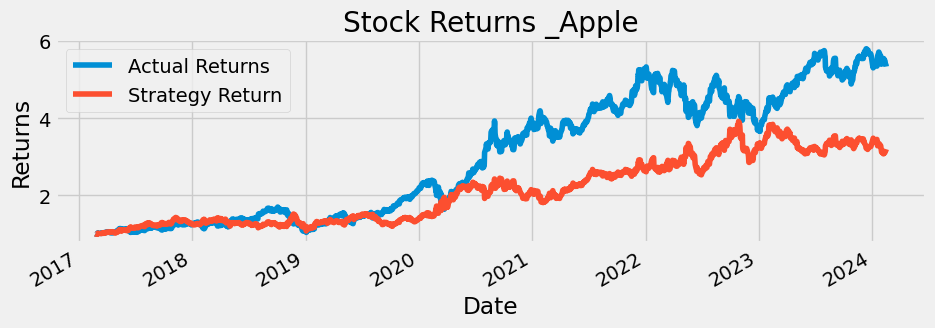

In [16]:
# Plot Strategy Returns to examine performance
(1 +macd_signals_df[['Actual Returns','Strategy Return']]).cumprod().plot(figsize=(10,3))
plt.legend()
plt.title("Stock Returns _Apple")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

In [17]:
macd_signals_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Actual Returns',
       'MACD', 'SIGNAL', 'Trigger', 'Strategy Return', 'Cum Return',
       'Cum SReturn'],
      dtype='object')

## **Step 3: Split the data into Features and Target for Machine Learning Models.**

In [18]:
# Assign a copy of the MACD and Signal columns to a features DataFrame called X
X = macd_signals_df[['MACD', 'SIGNAL']].shift().dropna()

# Review the DataFrame
X.head(6)

,MACD,SIGNAL
Date,,
2017-02-22,0.000000,0.000000
2017-02-23,0.002300,0.001278
2017-02-24,-0.001566,0.000112
2017-02-27,-0.002113,-0.000642
2017-02-28,0.000321,-0.000355
2017-03-01,0.002419,0.000397


In [19]:
# Create the target set selecting the Signal column and assiging it to y
y = macd_signals_df['Trigger'].shift()
y[:6]
# Review the value counts
# y.value_counts()

Date
2017-02-21    NaN
2017-02-22    1.0
2017-02-23    1.0
2017-02-24   -1.0
2017-02-27   -1.0
2017-02-28    1.0
Name: Trigger, dtype: float64

In [20]:
len_dataset=len(X)
len_dataset

1759

In [21]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2017-02-22 00:00:00


In [22]:
# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=48)

# Display the training end date
print(training_end)

2021-02-22 00:00:00


In [23]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()


,MACD,SIGNAL
Date,,
2021-02-16,1.339674,1.839985
2021-02-17,1.043021,1.680592
2021-02-18,0.611250,1.466724
2021-02-19,0.175860,1.208551
2021-02-22,-0.154499,0.935941


In [24]:
print(training_end+DateOffset(day=1))

2021-02-01 00:00:00


In [25]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,MACD,SIGNAL
Date,,
2021-02-22,-0.154499,0.935941
2021-02-23,-0.720284,0.604696
2021-02-24,-1.166523,0.250452
2021-02-25,-1.543530,-0.108344
2021-02-26,-2.169122,-0.520500


,MACD,SIGNAL
Date,,
2024-02-12,-0.251576,-0.186991
2024-02-13,-0.358701,-0.221333
2024-02-14,-0.606863,-0.298439
2024-02-15,-0.865373,-0.411826
2024-02-16,-1.081180,-0.545697


## **Step 4: Using different Classifier Model from SKLearn's  learning method to fit the training data and make predictions based on the testing data. Review the predictions.**

In [26]:
# Scale & fit the feature DataFrames through pipeline

# Implementing SVM classifier from SKLearn

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', svm.SVC(random_state=42))])

# Fit the model to the data using the training data
pipeline.fit(X_train, y_train)

# Use the testing data to make the model predictions
svm_pred = pipeline.predict(X_test)

# # Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.98      0.84      0.91       404
         1.0       0.84      0.98      0.91       349

    accuracy                           0.91       753
   macro avg       0.91      0.91      0.91       753
weighted avg       0.92      0.91      0.91       753



In [27]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = macd_signals_df['Actual Returns']

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted_SVM'] = svm_pred

# Add the strategy returns to the DataFrame
predictions_df['SVM Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted_SVM']
# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns
Date,,,
2021-02-22,-0.029799,-1.0,0.029799
2021-02-23,-0.001111,-1.0,0.001111
2021-02-24,-0.004052,-1.0,0.004052
2021-02-25,-0.034783,-1.0,0.034783
2021-02-26,0.002232,-1.0,-0.002232


,Actual Returns,Predicted_SVM,SVM Returns
Date,,,
2024-02-12,-0.009002,-1.0,0.009002
2024-02-13,-0.011274,-1.0,0.011274
2024-02-14,-0.004810,-1.0,0.004810
2024-02-15,-0.001575,-1.0,0.001575
2024-02-16,-0.008430,-1.0,0.008430


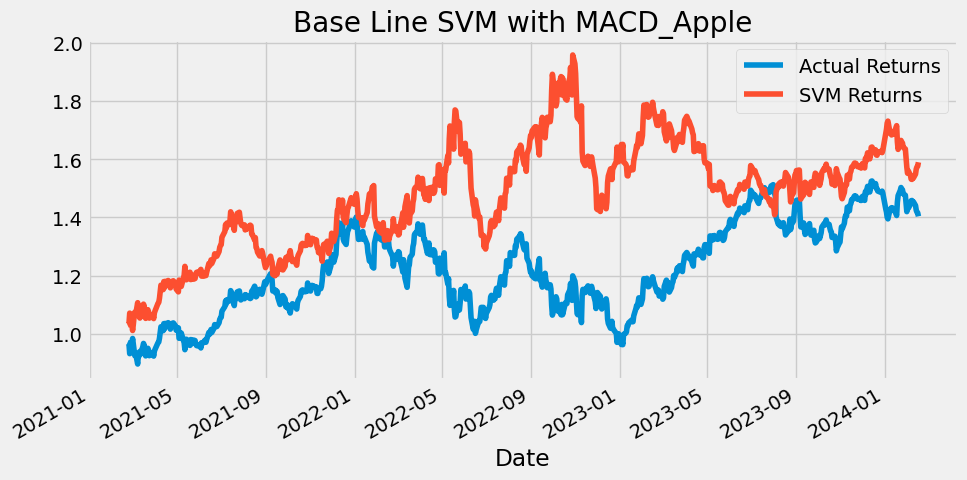

In [28]:
# Plot the actual returns versus the strategy returns
svm_comparison_plot=(1 + predictions_df[["Actual Returns", "SVM Returns"]]).cumprod().plot(figsize=(10,5),
    title="Base Line SVM with MACD_Apple")
svm_comparison_plot.get_figure().savefig("SVM_BaseLine_apple.png",bbox_inches="tight")

In [29]:
# Implementing Logistic Regression classifier from SKLearn

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', LogisticRegression(random_state=42))])

# Fit the model to the data using the training data
pipeline.fit(X_train, y_train)

# Use the testing data to make the model predictions
lrm_pred = pipeline.predict(X_test)

# # Use a classification report to evaluate the model using the predictions and testing data
lrm_testing_report = classification_report(y_test, lrm_pred)
# Print the classification report
print(lrm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.91      0.62      0.74       404
         1.0       0.68      0.93      0.78       349

    accuracy                           0.76       753
   macro avg       0.79      0.77      0.76       753
weighted avg       0.80      0.76      0.76       753



In [30]:

# Add LRM model predictions to the DataFrame
predictions_df['Predicted_LRM'] = lrm_pred

# Add the strategy returns to the DataFrame
predictions_df['LRM Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted_LRM']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns
Date,,,,,
2021-02-22,-0.029799,-1.0,0.029799,-1.0,0.029799
2021-02-23,-0.001111,-1.0,0.001111,-1.0,0.001111
2021-02-24,-0.004052,-1.0,0.004052,-1.0,0.004052
2021-02-25,-0.034783,-1.0,0.034783,-1.0,0.034783
2021-02-26,0.002232,-1.0,-0.002232,-1.0,-0.002232


,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns
Date,,,,,
2024-02-12,-0.009002,-1.0,0.009002,1.0,-0.009002
2024-02-13,-0.011274,-1.0,0.011274,1.0,-0.011274
2024-02-14,-0.004810,-1.0,0.004810,-1.0,0.004810
2024-02-15,-0.001575,-1.0,0.001575,-1.0,0.001575
2024-02-16,-0.008430,-1.0,0.008430,-1.0,0.008430


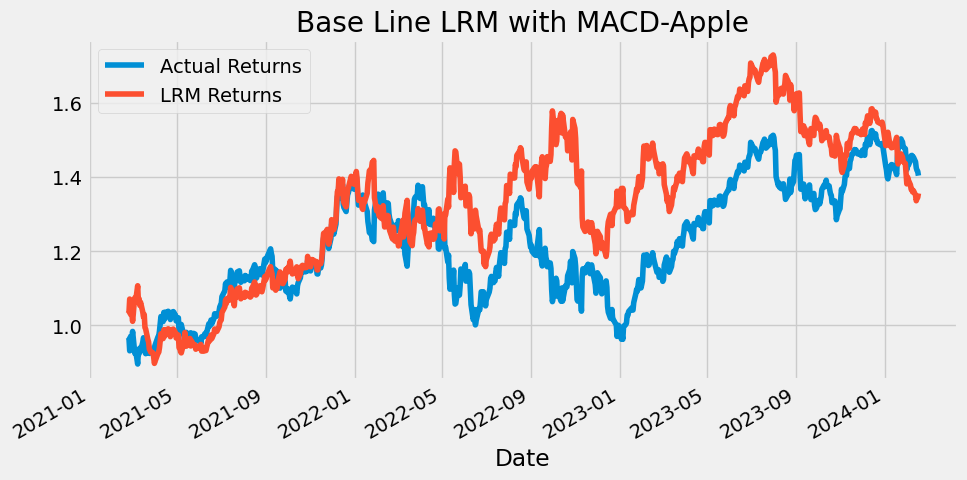

In [31]:
# Plot the actual returns versus the strategy returns
lrm_comparison_plot=(1 + predictions_df[["Actual Returns", "LRM Returns"]]).cumprod().plot(figsize=(10,5),
    title="Base Line LRM with MACD-Apple")
lrm_comparison_plot.get_figure().savefig("LRM_BaseLine_apple.png",bbox_inches="tight")

In [32]:

# From SkLearn-Neural Network, instantiate MLP classifier

pipeline = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', MLPClassifier(random_state=42))])

# Fit the model to the data using the training data
pipeline.fit(X_train, y_train)
# Use the testing data to make the model predictions
mlp_pred = pipeline.predict(X_test)

# # Use a classification report to evaluate the model using the predictions and testing data
mlp_testing_report = classification_report(y_test, mlp_pred)
# Print the classification report
print(mlp_testing_report)


              precision    recall  f1-score   support

        -1.0       0.88      0.59      0.71       404
         1.0       0.66      0.91      0.76       349

    accuracy                           0.74       753
   macro avg       0.77      0.75      0.74       753
weighted avg       0.78      0.74      0.73       753



In [33]:

# Add LRM model predictions to the DataFrame
predictions_df['Predicted_MLP'] = mlp_pred

# Add the strategy returns to the DataFrame
predictions_df['MLP Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted_MLP']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns,Predicted_MLP,MLP Returns
Date,,,,,,,
2021-02-22,-0.029799,-1.0,0.029799,-1.0,0.029799,-1.0,0.029799
2021-02-23,-0.001111,-1.0,0.001111,-1.0,0.001111,-1.0,0.001111
2021-02-24,-0.004052,-1.0,0.004052,-1.0,0.004052,-1.0,0.004052
2021-02-25,-0.034783,-1.0,0.034783,-1.0,0.034783,-1.0,0.034783
2021-02-26,0.002232,-1.0,-0.002232,-1.0,-0.002232,-1.0,-0.002232


,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns,Predicted_MLP,MLP Returns
Date,,,,,,,
2024-02-12,-0.009002,-1.0,0.009002,1.0,-0.009002,1.0,-0.009002
2024-02-13,-0.011274,-1.0,0.011274,1.0,-0.011274,1.0,-0.011274
2024-02-14,-0.004810,-1.0,0.004810,-1.0,0.004810,-1.0,0.004810
2024-02-15,-0.001575,-1.0,0.001575,-1.0,0.001575,-1.0,0.001575
2024-02-16,-0.008430,-1.0,0.008430,-1.0,0.008430,-1.0,0.008430


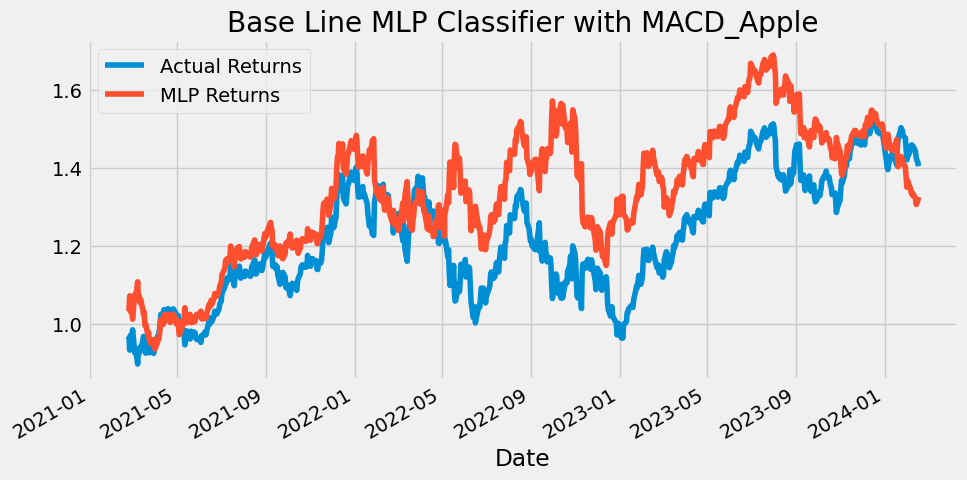

In [34]:
# Plot the actual returns versus the strategy returns
mlp_comparison_plot=(1 + predictions_df[["Actual Returns", "MLP Returns"]]).cumprod().plot(figsize=(10,5),
    title="Base Line MLP Classifier with MACD_Apple")
mlp_comparison_plot.get_figure().savefig("MLP_BaseLine_apple.png",bbox_inches="tight")

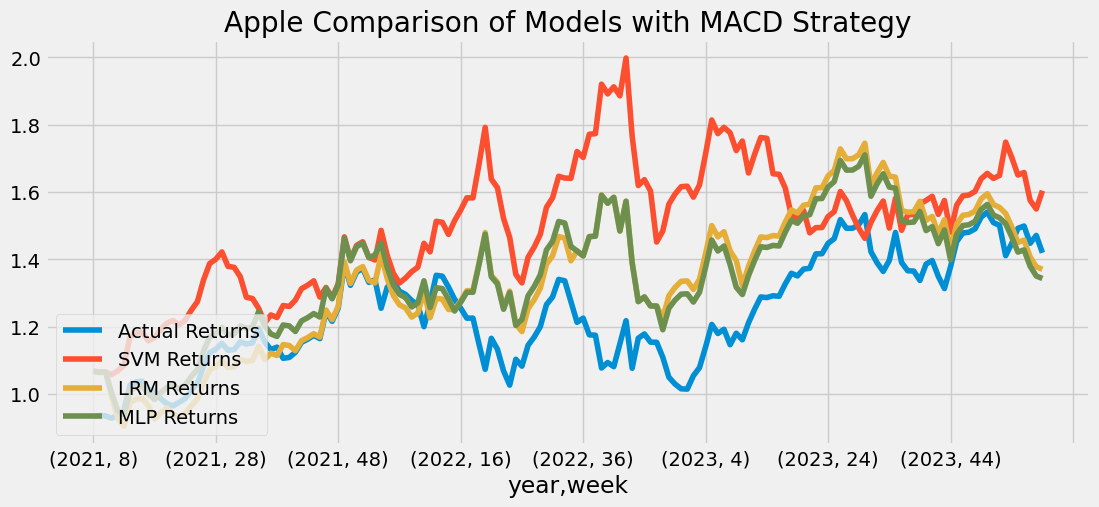

In [35]:
# Comparison of Different Models
predictions_df["Baseline_Strategy_Return"]=macd_signals_df["Strategy Return"]

weekly_returns = predictions_df.groupby(
    by=[
        predictions_df.index.isocalendar().year,
        predictions_df.index.isocalendar().week
    ]
).sum()

comparison_plot=(1 + weekly_returns[["Actual Returns","SVM Returns","LRM Returns","MLP Returns"]]
                 ).cumprod().plot(figsize=(12,5),
    title="Apple Comparison of Models with MACD Strategy")
comparison_plot.legend(loc='lower left')
mlp_comparison_plot.get_figure().savefig("Comparison_Chart_apple.png",bbox_inches="tight")

# weekly_returns.head(2)

# **Step 5: Back Testing MACD Startegy Through backtesting.py**

In [38]:
#Creating a function to calculate technical indicator "MACD","BBAND","RSI" from Finta
# data source is the original_df
def MACD_Ind(data):
    macd_df = TA.MACD(apple_df)
    return macd_df

In [40]:

# initiating trading strategy base class
class MyMACDStrategy(Strategy):

    #Initialize the strategy
    def init(self):
        price=self.data.Close

        #proceeding with MACD function
        self.macd= self.I(MACD_Ind,self.data)

    # Main strategy runtime method,
    def next(self):
        # extracting the MACD value and MACD_signal from MACD
        macd=self.macd[0]
        macd_signal=self.macd[1]

        # When MACD_Line crosses over Signal_Line, trigger to buy & vice versa
        if crossover(macd,macd_signal):
            self.buy()
        elif crossover(macd_signal,macd):
            self.sell()


 # Setting up initial investment and running backtest
backtest=Backtest(apple_df,MyMACDStrategy,cash=100000,commission=0,exclusive_orders=True)
stats=backtest.run()

#Plot the progression of the last backtest run.
backtest.plot()

# print key arguments of backtesting
print(stats)

Start                     2017-02-21 00:00:00
End                       2024-02-16 00:00:00
Duration                   2551 days 00:00:00
Exposure Time [%]                   99.829545
Equity Final [$]                312580.632729
Equity Peak [$]                 361855.409233
Return [%]                         212.580633
Buy & Hold Return [%]              433.460136
Return (Ann.) [%]                   17.725236
Volatility (Ann.) [%]               34.017007
Sharpe Ratio                          0.52107
Sortino Ratio                        0.913912
Calmar Ratio                         0.547926
Max. Drawdown [%]                  -32.349668
Avg. Drawdown [%]                   -5.251425
Max. Drawdown Duration      476 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                  125
Win Rate [%]                             44.0
Best Trade [%]                      26.334044
Worst Trade [%]                    -12.018483
Avg. Trade [%]                    

# **Evaluate a New Strategy Simple Moving Average**

## **Generate a new trading signals using Simple Moving Average (SMA).**




In [41]:

# Create a new clean copy of the DataFrame
sma_signals_df =apple_df.copy()

# calculate the daily returns
sma_signals_df["Actual Return"]=sma_signals_df["Close"].pct_change().dropna()

# Set the short window and long windows
short_window =20
long_window =100

# Add the SMA technical indicators for the short and long windows
sma_signals_df["SMA_Short"] = sma_signals_df["Close"].rolling(window=short_window).mean()
sma_signals_df["SMA_Long"] = sma_signals_df["Close"].rolling(window=long_window).mean()

sma_signals_df=sma_signals_df.dropna()

display(sma_signals_df.head())
display(sma_signals_df.tail())

,Open,High,Low,Close,Adj Close,Volume,Actual Return,SMA_Short,SMA_Long
2017-07-13,36.375000,37.122501,36.360001,36.942501,34.627880,100797600,0.013929,36.217125,36.324700
2017-07-14,36.992500,37.332500,36.832500,37.259998,34.925488,80528400,0.008594,36.276500,36.355550
2017-07-17,37.205002,37.724998,37.142502,37.389999,35.047337,95174000,0.003489,36.367625,36.386675
2017-07-18,37.299999,37.532501,37.167500,37.520000,35.169201,71475200,0.003477,36.414375,36.420550
2017-07-19,37.619999,37.855000,37.487499,37.755001,35.389481,83692000,0.006263,36.489500,36.456450


,Open,High,Low,Close,Adj Close,Volume,Actual Return,SMA_Short,SMA_Long
2024-02-12,188.419998,188.669998,186.789993,187.149994,187.149994,41781900,-0.009002,189.212499,184.6256
2024-02-13,185.770004,186.210007,183.509995,185.039993,185.039993,56529500,-0.011274,189.282999,184.7211
2024-02-14,185.320007,185.529999,182.440002,184.149994,184.149994,54630500,-0.004810,189.356499,184.8233
2024-02-15,183.550003,184.490005,181.350006,183.860001,183.860001,65434500,-0.001575,189.117999,184.9140
2024-02-16,183.419998,184.850006,181.669998,182.309998,182.309998,49701400,-0.008430,188.655499,184.9763


In [42]:

# Create a new column in the trading_df called signal setting its value to zero.
sma_signals_df["Signal"] = 0.0
sma_signals_df["Position"]=0.0

# Create the signal to buy

sma_signals_df.loc[(sma_signals_df["SMA_Short"] >= sma_signals_df["SMA_Long"] ), "Signal"] = 1

# Create the signal to sell
sma_signals_df.loc[(sma_signals_df["SMA_Short"] < sma_signals_df["SMA_Long"] ), "Signal"]=-1

# Iterate through the DataFrame and determine when to enter and exit positions
for i in range(1, len(sma_signals_df)):
    if sma_signals_df['SMA_Short'][i] > sma_signals_df['SMA_Long'][i] and sma_signals_df['Position'][i-1] >= 0:
        sma_signals_df.loc[sma_signals_df.index[i], 'Position'] = -1   # Enter short
    elif sma_signals_df['SMA_Short'][i] > sma_signals_df['SMA_Long'][i] and sma_signals_df['Signal'][i-1] == -1:
        sma_signals_df.loc[sma_signals_df.index[i], 'Position'] = 0   # Exit short
    elif sma_signals_df['SMA_Short'][i] < sma_signals_df['SMA_Long'][i] and sma_signals_df['Position'][i-1] <= 0:
        sma_signals_df.loc[sma_signals_df.index[i], 'Position']  = 1   # Enter long
    elif sma_signals_df['SMA_Short'][i] < sma_signals_df['SMA_Long'][i] and sma_signals_df['Position'][i-1] == 1:
        sma_signals_df.loc[sma_signals_df.index[i], 'Position'] = 0   # Exit long
    else:
        sma_signals_df.loc[sma_signals_df.index[i], 'Position'] = sma_signals_df['Position'][i-1]  # Hold position


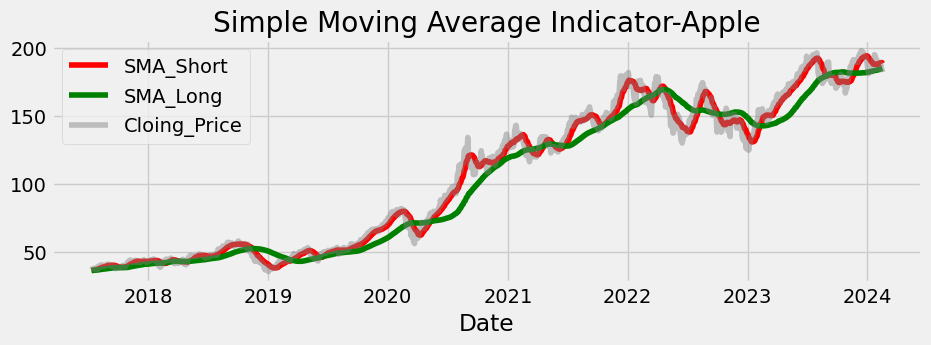

In [43]:
# Plot SMA  to view its working

plt.figure(figsize=(10,3))
plt.plot(sma_signals_df["SMA_Short"],label="SMA_Short",color="red")
plt.plot(sma_signals_df["SMA_Long"],label="SMA_Long",color="green")
plt.plot(sma_signals_df["Close"],label="Cloing_Price",color="grey",alpha=.45)
plt.legend()
plt.title("Simple Moving Average Indicator-Apple")
plt.xlabel("Date")
plt.show()

In [44]:
sma_signals_df["Signal"].value_counts()

 1.0    1212
-1.0     449
Name: Signal, dtype: int64

In [45]:
sma_signals_df["Position"].value_counts()

-1.0    1212
 1.0     227
 0.0     222
Name: Position, dtype: int64

In [46]:

# Calculate the strategy returns and add them to the sma_signal DataFrame
sma_signals_df["Strategy Return"]= sma_signals_df['Actual Return'] * sma_signals_df['Signal'].shift()
# Review the DataFrame
display(sma_signals_df.head())
display(sma_signals_df.tail())

,Open,High,Low,Close,Adj Close,Volume,Actual Return,SMA_Short,SMA_Long,Signal,Position,Strategy Return
2017-07-13,36.375000,37.122501,36.360001,36.942501,34.627880,100797600,0.013929,36.217125,36.324700,-1.0,0.0,NaN
2017-07-14,36.992500,37.332500,36.832500,37.259998,34.925488,80528400,0.008594,36.276500,36.355550,-1.0,1.0,-0.008594
2017-07-17,37.205002,37.724998,37.142502,37.389999,35.047337,95174000,0.003489,36.367625,36.386675,-1.0,0.0,-0.003489
2017-07-18,37.299999,37.532501,37.167500,37.520000,35.169201,71475200,0.003477,36.414375,36.420550,-1.0,1.0,-0.003477
2017-07-19,37.619999,37.855000,37.487499,37.755001,35.389481,83692000,0.006263,36.489500,36.456450,1.0,-1.0,-0.006263


,Open,High,Low,Close,Adj Close,Volume,Actual Return,SMA_Short,SMA_Long,Signal,Position,Strategy Return
2024-02-12,188.419998,188.669998,186.789993,187.149994,187.149994,41781900,-0.009002,189.212499,184.6256,1.0,-1.0,-0.009002
2024-02-13,185.770004,186.210007,183.509995,185.039993,185.039993,56529500,-0.011274,189.282999,184.7211,1.0,-1.0,-0.011274
2024-02-14,185.320007,185.529999,182.440002,184.149994,184.149994,54630500,-0.004810,189.356499,184.8233,1.0,-1.0,-0.004810
2024-02-15,183.550003,184.490005,181.350006,183.860001,183.860001,65434500,-0.001575,189.117999,184.9140,1.0,-1.0,-0.001575
2024-02-16,183.419998,184.850006,181.669998,182.309998,182.309998,49701400,-0.008430,188.655499,184.9763,1.0,-1.0,-0.008430


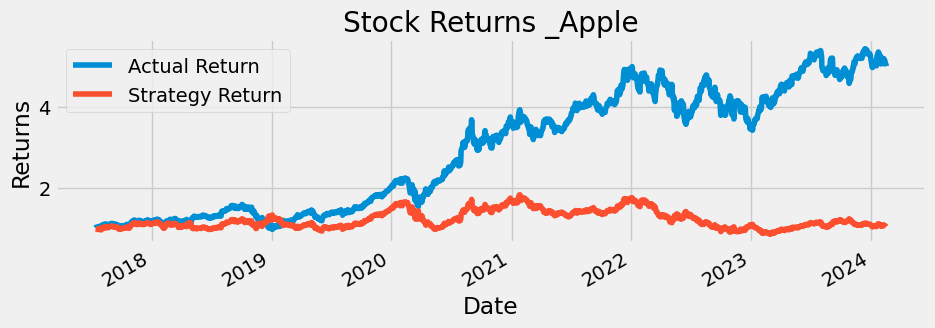

In [47]:
# Plot Strategy Returns to examine Strategy performance
(1 + sma_signals_df[["Actual Return",'Strategy Return']]).cumprod().plot(figsize=(10,3))
plt.legend()
plt.title("Stock Returns _Apple")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

## **Step 3: Split the data into Features and Target for Machine Learning Models.**

In [48]:
# Assign a copy of the SMA and Signal columns to a features DataFrame called X
XSMA = sma_signals_df[["Adj Close",'SMA_Short',"SMA_Long"]].shift().dropna()
ySma=sma_signals_df["Position"]


In [49]:
sma_signals_df["Position"].value_counts()

-1.0    1212
 1.0     227
 0.0     222
Name: Position, dtype: int64

In [50]:
# Select the start of the training period
training_begin = XSMA.index.min()
# Select the ending period for the training data with an offset of 36 months
training_end = XSMA.index.min() + DateOffset(months=48)


In [51]:
# Generate the X_train and y_train DataFrames
XSma_train = XSMA.loc[training_begin:training_end]
ySma_train = ySma.loc[training_begin:training_end]

# Review the DataFrame
display(XSma_train.head())
display(XSma_train.tail())

,Adj Close,SMA_Short,SMA_Long
2017-07-14,34.627880,36.217125,36.324700
2017-07-17,34.925488,36.276500,36.355550
2017-07-18,35.047337,36.367625,36.386675
2017-07-19,35.169201,36.414375,36.420550
2017-07-20,35.389481,36.489500,36.456450


,Adj Close,SMA_Short,SMA_Long
2021-07-08,142.333405,133.575001,128.0814
2021-07-09,141.023972,134.380501,128.1601
2021-07-12,142.865051,135.330501,128.2793
2021-07-13,142.264481,136.188001,128.4159
2021-07-14,143.386810,136.946001,128.5752


In [52]:
# Import the RandomOverSampler module form imbalanced-learn to resample the data
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
rus = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_resampled, y_resampled = rus.fit_resample(XSma_train, ySma_train)

In [53]:
y_resampled.value_counts()

 1.0    793
 0.0    793
-1.0    793
Name: Position, dtype: int64

In [54]:
# Generate the X_test and y_test DataFrames
XSma_test = XSMA.loc[training_end:]
ySma_test = ySma.loc[training_end:]

# Review the X_test DataFrame
display(XSma_test.head())
display(XSma_test.tail())

,Adj Close,SMA_Short,SMA_Long
2021-07-14,143.386810,136.946001,128.5752
2021-07-15,146.842529,137.921501,128.7680
2021-07-16,146.182907,138.838001,128.9928
2021-07-19,144.125259,139.568002,129.1981
2021-07-20,140.246170,140.167501,129.3691


,Adj Close,SMA_Short,SMA_Long
2024-02-12,188.850006,189.150999,184.5448
2024-02-13,187.149994,189.212499,184.6256
2024-02-14,185.039993,189.282999,184.7211
2024-02-15,184.149994,189.356499,184.8233
2024-02-16,183.860001,189.117999,184.9140


## **Step 4: Using different classifier model from SKLearn's  learning method to fit the training data and make predictions based on the testing data. Review the predictions.**



In [55]:
# Scale & fit the feature DataFrames through pipeline

# Imlementing SVM classifier from SKLearn

pipeline1 = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', svm.SVC(random_state=42))])

# Fit the model to the data using the training data
pipeline1.fit(X_resampled, y_resampled)

# Use the testing data to make the model predictions
svmbb_pred = pipeline1.predict(XSma_test)

# # Use a classification report to evaluate the model using the predictions and testing data
svmbb_testing_report = classification_report(ySma_test, svmbb_pred)
# Print the classification report
print(svmbb_testing_report)

              precision    recall  f1-score   support

        -1.0       0.81      0.90      0.85       420
         0.0       0.38      0.60      0.47       116
         1.0       0.50      0.03      0.05       118

    accuracy                           0.69       654
   macro avg       0.56      0.51      0.46       654
weighted avg       0.68      0.69      0.64       654



In [56]:

# Create a predictions DataFrame
predictionsbb_df = pd.DataFrame(index=XSma_test.index)

# Add the actual returns to the DataFrame
predictionsbb_df['Actual Returns'] = sma_signals_df['Actual Return']

# Add the SVM model predictions to the DataFrame
predictionsbb_df['Predicted_SVM'] = svmbb_pred

# Add the strategy returns to the DataFrame
predictionsbb_df['SVM Returns'] = predictionsbb_df['Actual Returns'] * predictionsbb_df['Predicted_SVM']
# Review the DataFrame
display(predictionsbb_df.head())
display(predictionsbb_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns
2021-07-14,0.024100,-1.0,-0.024100
2021-07-15,-0.004492,-1.0,0.004492
2021-07-16,-0.014076,-1.0,0.014076
2021-07-19,-0.026914,-1.0,0.026914
2021-07-20,0.025974,-1.0,-0.025974


,Actual Returns,Predicted_SVM,SVM Returns
2024-02-12,-0.009002,-1.0,0.009002
2024-02-13,-0.011274,-1.0,0.011274
2024-02-14,-0.004810,-1.0,0.004810
2024-02-15,-0.001575,-1.0,0.001575
2024-02-16,-0.008430,-1.0,0.008430


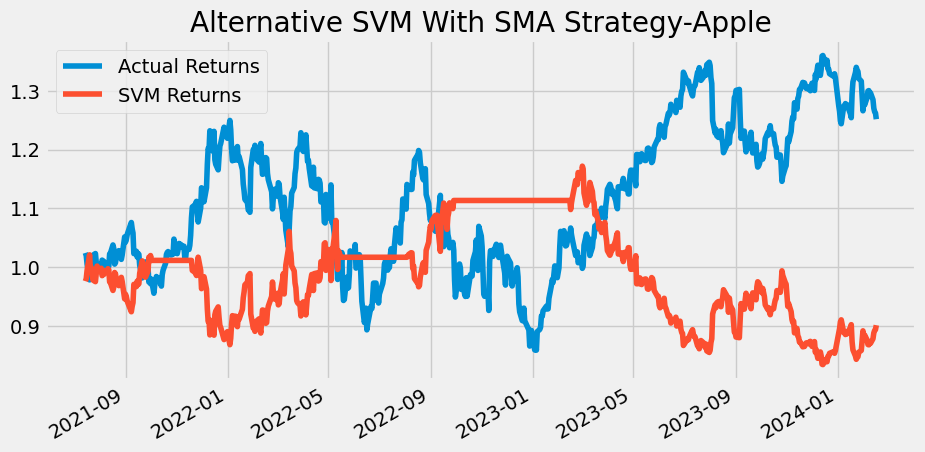

In [57]:
# Plot the actual returns versus the strategy returns
svmbb_comparison_plot=(1 + predictionsbb_df[["Actual Returns", "SVM Returns"]]).cumprod().plot(figsize=(10,5),
    title="Alternative SVM With SMA Strategy-Apple")
svm_comparison_plot.get_figure().savefig("SVMbb_BaseLine_apple.png",bbox_inches="tight")

In [58]:
# Imlementing Logistic Regression classifier from SKLearn

pipeline1 = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', LogisticRegression(random_state=42))])

# Fit the model to the data using the training data
pipeline1.fit(X_resampled, y_resampled)

# Use the testing data to make the model predictions
lrmbb_pred = pipeline1.predict(XSma_test)

# # Use a classification report to evaluate the model using the predictions and testing data
lrmbb_testing_report = classification_report(ySma_test, lrmbb_pred)
# Print the classification report
print(lrmbb_testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      0.79      0.88       420
         0.0       0.36      0.97      0.52       116
         1.0       0.50      0.04      0.08       118

    accuracy                           0.69       654
   macro avg       0.62      0.60      0.50       654
weighted avg       0.80      0.69      0.68       654



In [59]:

# Add LRM model predictions to the DataFrame
predictionsbb_df['Predicted_LRM'] = lrmbb_pred

# Add the strategy returns to the DataFrame
predictionsbb_df['LRM Returns'] = predictionsbb_df['Actual Returns'] * predictionsbb_df['Predicted_LRM']

# Review the DataFrame
display(predictionsbb_df.head())
display(predictionsbb_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns
2021-07-14,0.024100,-1.0,-0.024100,-1.0,-0.024100
2021-07-15,-0.004492,-1.0,0.004492,-1.0,0.004492
2021-07-16,-0.014076,-1.0,0.014076,-1.0,0.014076
2021-07-19,-0.026914,-1.0,0.026914,-1.0,0.026914
2021-07-20,0.025974,-1.0,-0.025974,-1.0,-0.025974


,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns
2024-02-12,-0.009002,-1.0,0.009002,0.0,-0.0
2024-02-13,-0.011274,-1.0,0.011274,0.0,-0.0
2024-02-14,-0.004810,-1.0,0.004810,0.0,-0.0
2024-02-15,-0.001575,-1.0,0.001575,0.0,-0.0
2024-02-16,-0.008430,-1.0,0.008430,0.0,-0.0


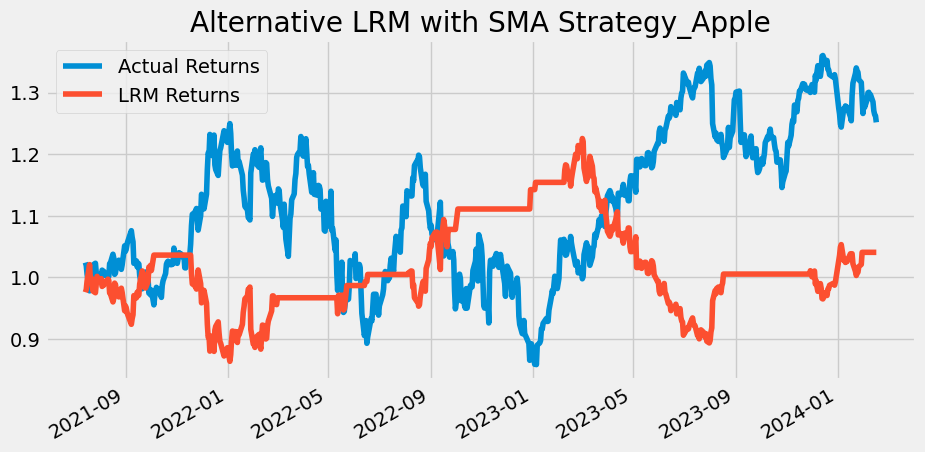

In [60]:
# Plot the actual returns versus the strategy returns
lrmbb_comparison_plot=(1 + predictionsbb_df[["Actual Returns", "LRM Returns"]]).cumprod().plot(figsize=(10,5),
    title="Alternative LRM with SMA Strategy_Apple")
lrmbb_comparison_plot.get_figure().savefig("LRMbb_apple.png",bbox_inches="tight")

In [61]:

# From SkLearn-Neural Network, instantiate MLP classifier

pipeline1 = Pipeline(steps=[('scaler', MinMaxScaler()),
                   ('model', MLPClassifier(random_state=42))])

# Fit the model to the data using the training data
pipeline1.fit(X_resampled,y_resampled)
# Use the testing data to make the model predictions
mlpbb_pred = pipeline1.predict(XSma_test)

# # Use a classification report to evaluate the model using the predictions and testing data
mlpbb_testing_report = classification_report(ySma_test, mlpbb_pred)
# Print the classification report
print(mlpbb_testing_report)


              precision    recall  f1-score   support

        -1.0       1.00      0.91      0.95       420
         0.0       0.40      0.66      0.50       116
         1.0       0.50      0.33      0.40       118

    accuracy                           0.76       654
   macro avg       0.63      0.63      0.62       654
weighted avg       0.80      0.76      0.77       654



In [62]:

# Add LRM model predictions to the DataFrame
predictionsbb_df['Predicted_MLP'] = mlpbb_pred

# Add the strategy returns to the DataFrame
predictionsbb_df['MLP Returns'] = predictionsbb_df['Actual Returns'] * predictionsbb_df['Predicted_MLP']

# Review the DataFrame
display(predictionsbb_df.head())
display(predictionsbb_df.tail())

,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns,Predicted_MLP,MLP Returns
2021-07-14,0.024100,-1.0,-0.024100,-1.0,-0.024100,-1.0,-0.024100
2021-07-15,-0.004492,-1.0,0.004492,-1.0,0.004492,-1.0,0.004492
2021-07-16,-0.014076,-1.0,0.014076,-1.0,0.014076,-1.0,0.014076
2021-07-19,-0.026914,-1.0,0.026914,-1.0,0.026914,-1.0,0.026914
2021-07-20,0.025974,-1.0,-0.025974,-1.0,-0.025974,-1.0,-0.025974


,Actual Returns,Predicted_SVM,SVM Returns,Predicted_LRM,LRM Returns,Predicted_MLP,MLP Returns
2024-02-12,-0.009002,-1.0,0.009002,0.0,-0.0,-1.0,0.009002
2024-02-13,-0.011274,-1.0,0.011274,0.0,-0.0,-1.0,0.011274
2024-02-14,-0.004810,-1.0,0.004810,0.0,-0.0,-1.0,0.004810
2024-02-15,-0.001575,-1.0,0.001575,0.0,-0.0,-1.0,0.001575
2024-02-16,-0.008430,-1.0,0.008430,0.0,-0.0,0.0,-0.000000


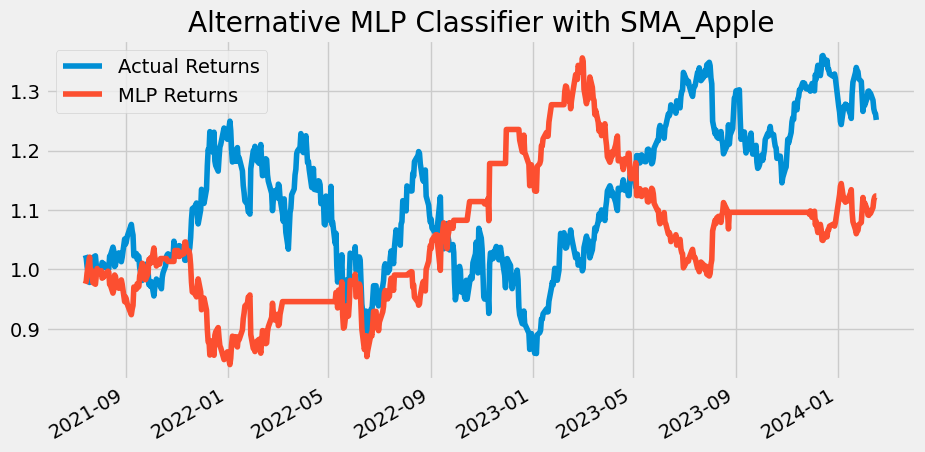

In [63]:
# Plot the actual returns versus the strategy returns
mlpbb_comparison_plot=(1 + predictionsbb_df[["Actual Returns", "MLP Returns"]]).cumprod().plot(figsize=(10,5),
    title="Alternative MLP Classifier with SMA_Apple")
mlpbb_comparison_plot.get_figure().savefig("MLPbb_apple.png",bbox_inches="tight")

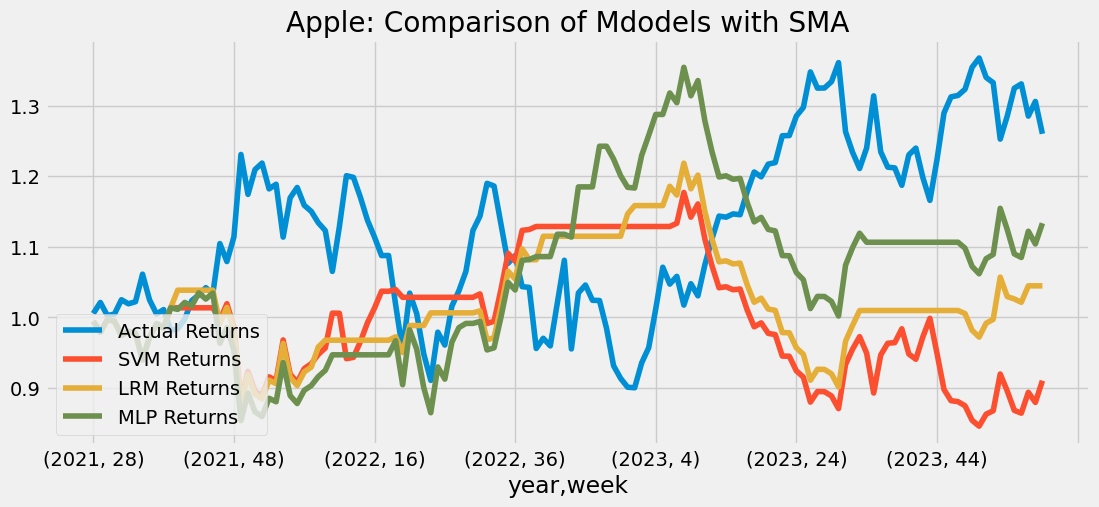

In [64]:
# Comparison of Different Models

weekly_returns = predictionsbb_df.groupby(
    by=[
        predictionsbb_df.index.isocalendar().year,
       predictionsbb_df.index.isocalendar().week
    ]
).sum()

comparisonbb_plot=(1 + weekly_returns[["Actual Returns","SVM Returns","LRM Returns","MLP Returns"]]
                 ).cumprod().plot(figsize=(12,5),
    title="Apple: Comparison of Mdodels with SMA")
comparisonbb_plot.legend(loc='lower left')
comparisonbb_plot.get_figure().savefig("Comparison_Chart_apple.png",bbox_inches="tight")

# weekly_returns.head(2)

In [66]:
from backtesting.test import SMA


class MySMAStrategy(Strategy):

    #Initialize the strategy
    def init(self):
      price=self.data.Close
      self.sma1=self.I(SMA,price,20)
      self.sma2=self.I(SMA,price,100)


    # Main strategy runtime method,
    def next(self):
       if crossover(self.sma1,self.sma2):
            self.buy()

       elif crossover(self.sma2,self.sma2):
            self.sell()

 # Setting up initial investment and running backtest
my_strat=Backtest(apple_df,MySMAStrategy,cash=100000,commission=0,exclusive_orders=True)
stats1 = my_strat.run()
my_strat.plot()
print(stats1)

Start                     2017-02-21 00:00:00
End                       2024-02-16 00:00:00
Duration                   2551 days 00:00:00
Exposure Time [%]                   94.090909
Equity Final [$]                484238.795166
Equity Peak [$]                 523020.401611
Return [%]                         384.238795
Buy & Hold Return [%]              433.460136
Return (Ann.) [%]                   25.339534
Volatility (Ann.) [%]                38.24868
Sharpe Ratio                         0.662494
Sortino Ratio                        1.243906
Calmar Ratio                         0.654309
Max. Drawdown [%]                  -38.727166
Avg. Drawdown [%]                   -4.717114
Max. Drawdown Duration      525 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                   12
Win Rate [%]                        66.666667
Best Trade [%]                      69.354485
Worst Trade [%]                     -7.567468
Avg. Trade [%]                    